# Import

In [362]:
!pip install yfinance
!pip install apimoex
!pip install livelossplot

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RNN, SimpleRNN, BatchNormalization, Bidirectional, TimeDistributed

import yfinance as yf
from livelossplot import PlotLossesKeras

import requests
import apimoex

from collections import Counter
from tqdm import tqdm
import random
import time

In [4]:
def do_smooth(df, n_window):
    df['Open_not_smooth'] = df['Open']
    df['Open'] = round(df['Open'].rolling(window=n_window).mean().iloc[n_window-1:], 2)
    df = df[n_window:]
    return df


def download_stocks(ticker = 'GAZP', start = '2020-01-01', end = '2023-01-01', interval=24):
    time.sleep(0.01) 
    with requests.Session() as session:
        data = apimoex.get_market_candles(session, ticker, start=start, end=end, interval=interval)
        df = pd.DataFrame(data)
        df.columns = ['Date', 'Open', 'Close', 'High', 'Low', 'Value']
        df.set_index('Date', inplace=True)
        df = df[['Open', 'High', 'Low', 'Close', 'Value']]
        # display(pd.concat([df.head(3), df.tail(3)]))
        return df

# LSTM

In [294]:
# загружаем данные: General Electric Company

stock = 'GE'
start = '1970-05-08'
end = '2022-06-01'

df = yf.download(stock, start=start, end=end)
    
n_window = 10
# df = do_smooth(df, n_window=n_window)  - сглаживание

df.shape

[*********************100%***********************]  1 of 1 completed


(13133, 6)

In [295]:
pd.concat([df.head(2), df.tail(2)])

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1970-05-08,4.386409,4.386409,4.292582,4.331677,0.900777,420455
1970-05-11,4.339496,4.394228,4.339496,4.339496,0.902404,401271
2022-05-27,60.335674,61.498829,60.101482,61.483215,61.217834,6240904
2022-05-31,60.850899,61.701794,60.702576,61.116314,60.852509,6649671


In [309]:
data = df.filter(['Close']).values

sc = MinMaxScaler()
data = sc.fit_transform(data.reshape(-1, 1))

training_size = int(len(data) * 0.8)
testing_size = len(data) - training_size
train_data, test_data = data[:training_size], data[training_size:]


def create_dataset(dataset, time_step=1):
    train_X, train_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        train_X.append(a)
        train_Y.append(dataset[i + time_step, 0])

    return np.array(train_X), np.array(train_Y)

In [310]:
time_step = 50

x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10455, 50, 1), (10455,), (2576, 50, 1), (2576,))

In [73]:
# Архитектура NN LSTM
# ----------------------------
# model = Sequential()

# model.add(Dense(units = 128, input_shape = (x_train.shape[1], 1), activation='relu'))
# model.add(LSTM(units = 64, activation='tanh', return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 32, activation='tanh', return_sequences = False))
# model.add(Dense(32))
# model.add(Dropout(0.2))

# model.add(Dense(1))


# ----------------------------
# model.add(Dense(units = 64, input_shape = (x_train.shape[1], 1), activation='relu'))
# model.add(Bidirectional(LSTM(units = 64, activation='tanh', return_sequences = True)))
# model.add(Dropout(0.2))

# # model.add(Dense(64, activation='relu'))
# model.add(Bidirectional(LSTM(units = 64, activation='tanh', return_sequences = False)))
# model.add(Dropout(0.2))

# model.add(Dense(64, activation='relu'))
# model.add(Bidirectional(LSTM(units = 64, activation='tanh', return_sequences = True)))
# model.add(Dropout(0.2))

# model.add(Dense(32, activation='relu'))
# model.add(Bidirectional(LSTM(units = 32, activation='tanh', return_sequences = True)))
# model.add(Dropout(0.2))
# ----------------------
# model.add(Dense(units = 50, input_shape = (x_train.shape[1], 1), activation='relu'))
# model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 50, activation='tanh', return_sequences = False))
# model.add(Dropout(0.2))
# --------------------------------
# model.add(Dense(units = 128, input_shape = (1, 24, 1), activation='relu'))
# model.add(LSTM(units = 64, activation='tanh', return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 32, activation='tanh', return_sequences = False))
# model.add(Dense(32))
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Dense(1)))
# model.add(Dense(1))

In [311]:
model = Sequential()

# model.add(Dense(units = 128, input_shape = (x_train.shape[1], 1), activation='relu'))
# model.add(LSTM(units = 64, activation='tanh', return_sequences = True))
# model.add(Dropout(0.25))
# model.add(LSTM(units = 64, activation='tanh', return_sequences = True))
# model.add(Dropout(0.25))
# model.add(LSTM(units = 32, activation='tanh', return_sequences = False))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.25))


# -------------------
model = Sequential()

model.add(Dense(units = 100, input_shape = (x_train.shape[1], 1), activation='relu'))
model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
model.add(Dense(50, activation='relu'))
model.add(LSTM(units = 50, activation='tanh', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 50, activation='tanh', return_sequences = False))

model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='relu'))
# -------------------

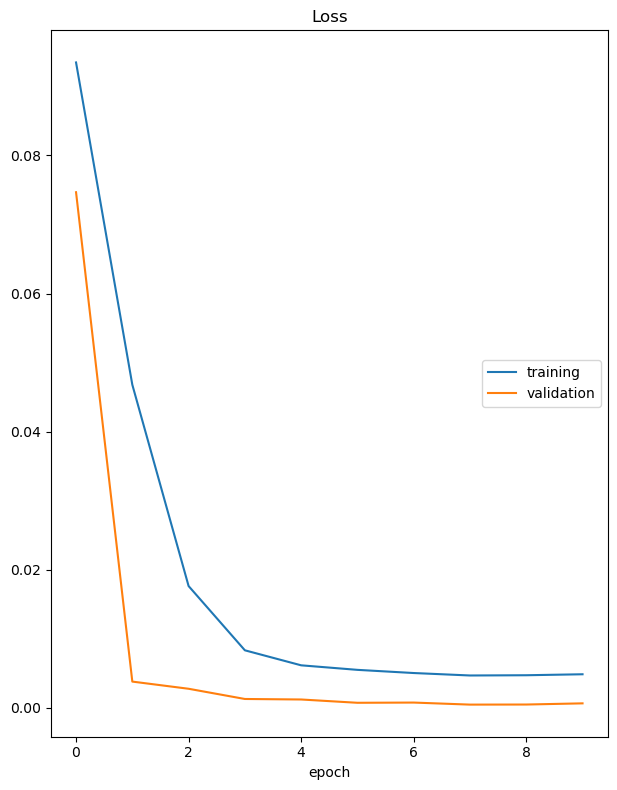

Loss
	training         	 (min:    0.005, max:    0.093, cur:    0.005)
	validation       	 (min:    0.000, max:    0.075, cur:    0.001)
21/21 [==============================] - 18s 877ms/step - loss: 0.0049 - val_loss: 6.4744e-04


In [312]:
cp = ModelCheckpoint('model/',
                     epsilon=0.01,
                     save_best_only=False, 
                     save_weights_only=False)

callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                         restore_best_weights=True,
                                         patience=3)


model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
#               metrics=['mae']
             )


history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_test, y_test),
                    batch_size=512, 
                    epochs=5, 
                    callbacks=[callback, PlotLossesKeras()], 
                    verbose=1,
                    shuffle=True)

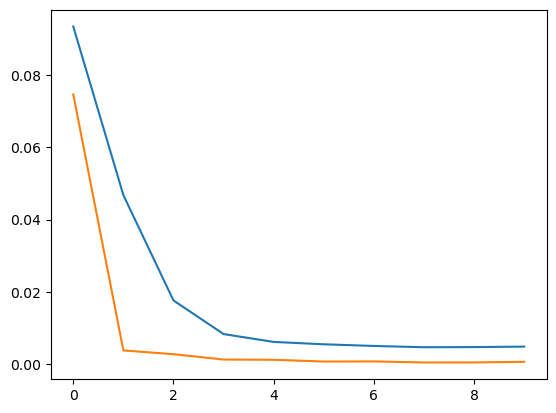

In [315]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [342]:
import plotly.graph_objects as go

hist = pd.DataFrame(history.history)

fig = go.Figure()
fig.add_trace(go.Scatter(x=hist['loss'], name='loss', mode='lines'))
fig.add_trace(go.Scatter(x=hist['val_loss'], name='val loss', mode='lines'))
fig.update_layout(title='history plot')
fig.show()

In [ ]:
# SAVING WEIGHTS

# from google.colab import files
# name = 'gpu_model_weights_14-08-2022.h5'
# model.save_weights(name)
# files.download(name)



# LOADING WEIGHTS TO NEW MODEL

# load_model = create_models()
# name = 'gpu_model_weights.h5'
# load_model.load_weights(name)

In [345]:
# from tensorflow.keras.models import load_model
# model = load_model('model/')

predictions = model.predict(x_test, batch_size=32).reshape(-1, 1)
predictions = sc.inverse_transform(predictions)


diff = predictions - y_test

print('MSE:', np.mean(diff**2))
print('MAE:', np.mean(abs(diff)))
print('RMSE:', np.sqrt(np.mean(diff**2)))
print('MAPE:', mean_absolute_percentage_error(y_test, predictions))

81/81 [==============================] - 3s 27ms/step
MSE: 14371.440099801828
MAE: 111.25427272144267
RMSE: 119.88094135350218
MAPE: 354.85009736150676


In [347]:
(predictions.shape), (y_test.shape)

((2576, 1), (2576,))

In [348]:
train = df.iloc[len(predictions):, :].copy()
valid = df.iloc[-len(predictions):, :].copy()
valid['Pred'] = predictions.ravel()

# Значения Predict и X_test

draw_from = '2015-06-01'

fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train['Close'], name='train close', fillcolor='blue'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], name='test close', fillcolor='red'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Pred'], name='predicitions on test', fillcolor='green'))

fig.update_layout(xaxis_range=[draw_from, pd.to_datetime(end) + timedelta(days=30*3)])

fig.show()

In [349]:
next_data = yf.download(stock, start=start, end=end)

# # next_data = download_stocks(ticker=ticker, start=start, end=end, interval=interval)

# next_data['Open_not_smooth'] = next_data['Close']
# next_data['Close'] = round(next_data['Open'].rolling(window=n_window).mean().iloc[n_window-1:], 2)
# next_data = next_data[n_window:]

new_df = next_data.filter(['Close'])

[*********************100%***********************]  1 of 1 completed


In [356]:
from tqdm.notebook import tqdm_notebook

prediction_days = 50
future_pred = np.array([])
w2 = window

last_60 = new_df[-w2:].values


for i in tqdm_notebook(range(prediction_days)):

    last_60 = last_60[-w2:]
    last_60_sc = sc.transform(last_60)
    
    x_ = []
    x_.append(last_60_sc)
    x_ = np.array(x_)
    x_ = np.reshape(x_, (x_.shape[0], x_.shape[1], 1))

    pred = model.predict(x_, verbose=0)
    pred = sc2.inverse_transform(pred)
    pred[0] = np.random.normal(loc=pred[0], scale=pred[0]*0.005, size=1) #add volatility

    future_pred = np.append(future_pred, pred[0])
    last_60 = np.vstack((last_60, pred))

  0%|          | 0/50 [00:00<?, ?it/s]

In [357]:
future_pred

array([ 98.29965973,  97.65304565,  96.86818695,  98.8354187 ,
        97.77840424,  98.43952942,  97.48749542,  98.05301666,
        98.72722626,  99.54592133,  98.87420654,  99.99091339,
       100.49211121, 100.33991241, 101.12687683, 101.15929413,
       102.55630493, 101.60151672, 102.05496216, 102.54023743,
       103.60480499, 103.69973755, 103.34762573, 104.05766296,
       104.06404877, 104.15927887, 104.82456207, 103.80233765,
       106.10899353, 105.72465515, 106.41159058, 105.92068481,
       105.68645477, 106.26988983, 106.14048767, 106.05552673,
       106.50707245, 107.07416534, 106.33653259, 106.69072723,
       106.74797058, 106.97733307, 106.89073944, 105.60411072,
       107.26351166, 106.0848465 , 105.92922211, 106.06194305,
       106.67477417, 106.10627747])

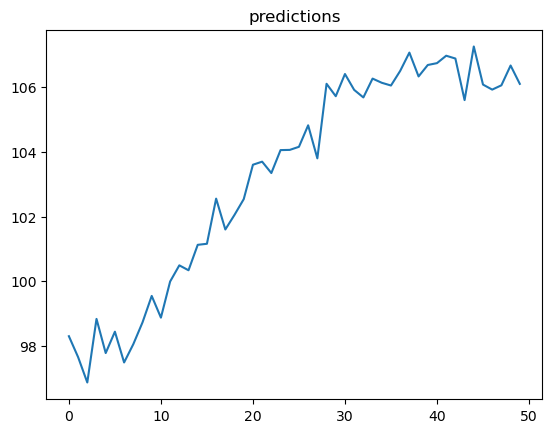

array([ 98.29965973,  97.65304565,  96.86818695,  98.8354187 ,
        97.77840424,  98.43952942,  97.48749542,  98.05301666,
        98.72722626,  99.54592133,  98.87420654,  99.99091339,
       100.49211121, 100.33991241, 101.12687683, 101.15929413,
       102.55630493, 101.60151672, 102.05496216, 102.54023743,
       103.60480499, 103.69973755, 103.34762573, 104.05766296,
       104.06404877, 104.15927887, 104.82456207, 103.80233765,
       106.10899353, 105.72465515, 106.41159058, 105.92068481,
       105.68645477, 106.26988983, 106.14048767, 106.05552673,
       106.50707245, 107.07416534, 106.33653259, 106.69072723,
       106.74797058, 106.97733307, 106.89073944, 105.60411072,
       107.26351166, 106.0848465 , 105.92922211, 106.06194305,
       106.67477417, 106.10627747])

In [358]:
plt.plot(future_pred)
plt.title('predictions')
plt.show()

print()
future_pred

In [359]:
future_data = yf.download(stock, period='max')
# future_data = next_data.copy()

future_days = prediction_days + 30

future_data_transform = future_data[future_data.index >= end].head(future_days).copy()
future_data_transform = future_data_transform[['Open']].copy()

future_df = future_data[future_data.index >= end].head(prediction_days).copy()
future_df['predictions'] = future_pred
future_df = future_df[['Open', 'predictions']].copy()

future_df['difference'] = future_df['Open'] - future_df['predictions']

[*********************100%***********************]  1 of 1 completed


In [360]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=valid.index, y=valid['Open'], name='real close'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['Pred'], name='test predicitions'))

fig.add_trace(go.Scatter(x=future_df.index, y=future_df['predictions'], name='future predicitions'))
fig.add_trace(go.Scatter(x=future_data_transform.index, y=future_data_transform['Open'], name=f'future real {future_days} days'))

fig.update_layout(xaxis_range=['2019-04-01', pd.to_datetime(end) + timedelta(days=30*6)])

fig.show()

Средняя разница: 49.198


,Open,predictions,difference
Date,,,
2022-06-01,61.733021,98.299660,-36.566639
2022-06-02,60.905544,97.653046,-36.747501
2022-06-03,59.906322,96.868187,-36.961864
2022-06-06,60.819672,98.835419,-38.015747
2022-06-07,60.039032,97.778404,-37.739372


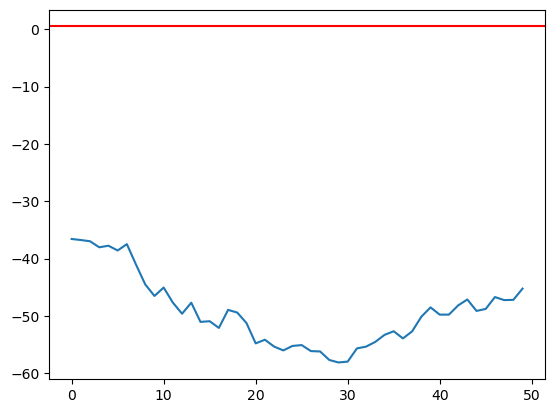

In [361]:
print('Средняя разница:', round(np.mean(abs(future_df.difference)), 3))

display(future_df.head())
print()

plt.plot(future_df.difference.values)
plt.axhline(y = 0.5, color = 'r', linestyle = '-')
# plt.yscale('log')
plt.show()

# Kmeans: Support-resistance-level detection

In [ ]:
from sklearn.cluster import KMeans

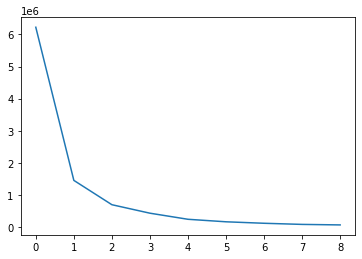

In [ ]:
K = range(1, 10)
values=[]
for k in K:
    kmeans_n = KMeans(n_clusters=k)
    kmeans_n.fit(x.reshape(-1, 1))
    values.append(kmeans_n.inertia_)

plt.plot(values)

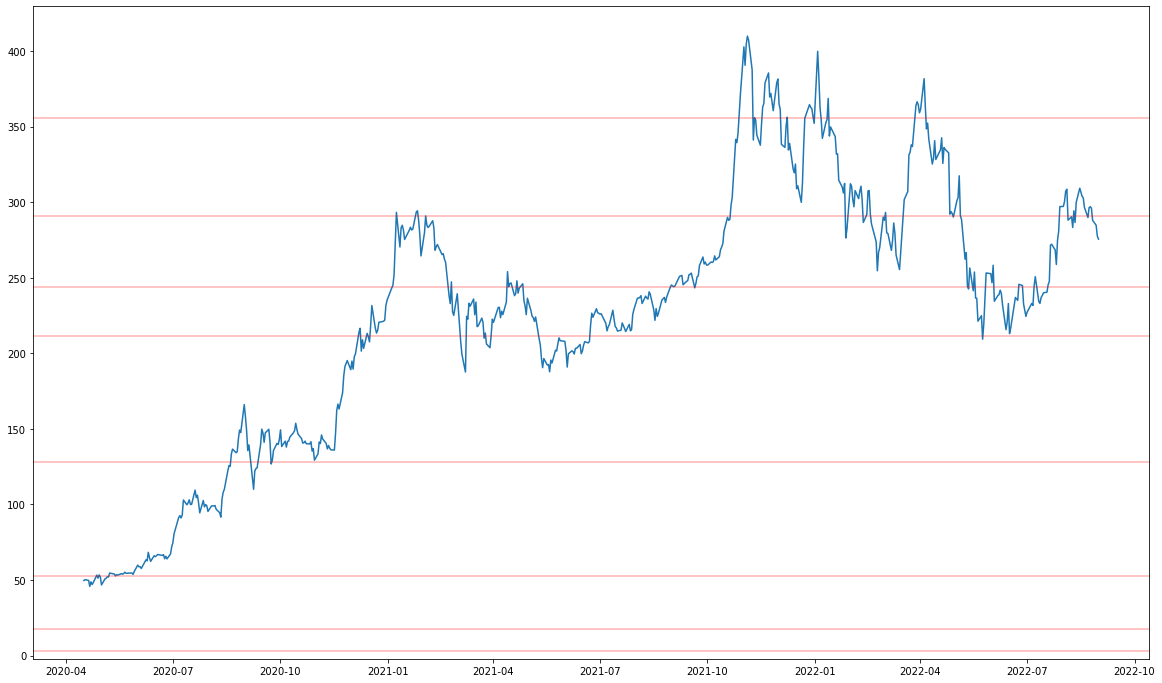

In [ ]:
x = np.array(df.Close)
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=150, tol=0.00001,).fit(x.reshape(-1, 1))
clusters = kmeans.predict(x.reshape(-1, 1))

plt.figure(figsize=(20, 12))

plt.plot(df.Close[-600:])

for line in kmeans.cluster_centers_:
    if line <= max(df.Close[-600:])+50:
      plt.axhline(y = line, color = 'r', linestyle = '-', alpha=0.3)

plt.show()

In [ ]:
plt.figure(figsize=(18, 7))

days_print = 500
# plt.plot(df.Open_not_smooth[-days_print:], alpha=0.7)
plt.plot(df.Open[-days_print:])

In [ ]:
def roll_dice():
    die_1 = random.randint(1, 6)
    die_2 = random.randint(1, 6)

    # Определим является ли значение на костях одинаковым
    if die_1 == die_2:
        same_num = True
    else:
        same_num = False
    return same_num

In [ ]:
# Архитектура NN RNN

# model_SimpleRNN = Sequential()

# model_SimpleRNN.add(Dense(units = 128, input_shape = (x_train.shape[1], 1), activation='relu'))
# model_SimpleRNN.add(SimpleRNN(units = 64, activation='tanh', return_sequences = True))
# model_SimpleRNN.add(Dropout(0.2))
# model_SimpleRNN.add(SimpleRNN(units = 32, activation='tanh', return_sequences = False))
# model_SimpleRNN.add(Dense(32))
# model_SimpleRNN.add(Dropout(0.2))

# model_SimpleRNN.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True, input_shape = (x_train.shape[1], 1)))
# model_SimpleRNN.add(Dropout(0.2))
# model_SimpleRNN.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True))
# model_SimpleRNN.add(Dropout(0.2))
# model_SimpleRNN.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True))
# model_SimpleRNN.add(Dropout(0.2))
# model_SimpleRNN.add(SimpleRNN(units = 50, activation='tanh', return_sequences = False))

# model_SimpleRNN.add(Dense(units = 128, input_shape = (x_train.shape[1], 1), activation='relu'))
# model_SimpleRNN.add(SimpleRNN(units = 128, activation='tanh', return_sequences = True))
# model_SimpleRNN.add(Dropout(0.3))

# model_SimpleRNN.add(Dense(64, activation='relu'))
# model_SimpleRNN.add(SimpleRNN(units = 64, activation='tanh', return_sequences = True))
# model_SimpleRNN.add(Dropout(0.3))

# model_SimpleRNN.add(Dense(64, activation='relu'))
# model_SimpleRNN.add(SimpleRNN(units = 64, activation='tanh', return_sequences = True))
# model_SimpleRNN.add(Dropout(0.3))

# model_SimpleRNN.add(Dense(32, activation='relu'))
# model_SimpleRNN.add(SimpleRNN(units = 32, activation='tanh', return_sequences = False))
# model_SimpleRNN.add(Dropout(0.3))

# model_SimpleRNN.add(Dense(1))

In [ ]:
model_SimpleRNN = Sequential()

model_SimpleRNN.add(Dense(units = 256, input_shape = (x_train.shape[1], 1), activation='relu'))
model_SimpleRNN.add(SimpleRNN(units = 256, activation='tanh', return_sequences = True))
model_SimpleRNN.add(Dropout(0.3))
model_SimpleRNN.add(SimpleRNN(units = 128, activation='tanh', return_sequences = False))
model_SimpleRNN.add(Dense(32))
model_SimpleRNN.add(Dropout(0.3))

model_SimpleRNN.add(Dense(1))

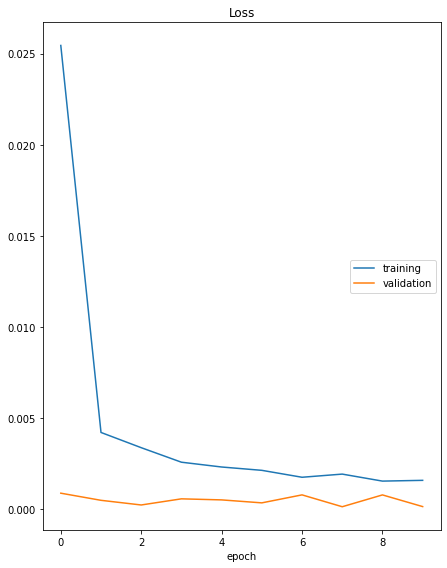

Loss
	training         	 (min:    0.002, max:    0.025, cur:    0.002)
	validation       	 (min:    0.000, max:    0.001, cur:    0.000)
299/299 [==============================] - 17s 57ms/step - loss: 0.0016 - val_loss: 1.4797e-04


In [ ]:
model_SimpleRNN.compile(optimizer='adam', loss='mse')

history = model_SimpleRNN.fit(x_train, y_train, validation_split = 0.2, batch_size=32, epochs=10, 
                    callbacks = [PlotLossesKeras()], verbose=1)

In [ ]:
predictions_SimpleRNN = model_SimpleRNN.predict(x_test)
predictions_SimpleRNN = sc.inverse_transform(predictions_SimpleRNN)
print()

diff_SimpleRNN = predictions_SimpleRNN - y_test

print('MSE:', np.mean(diff_SimpleRNN**2)) # сильной рост из-за небольшого количества отклонений
print('MAE:', np.mean(abs(diff_SimpleRNN))) # не так сильно растет ошибка 
print('RMSE:', np.sqrt(np.mean(diff_SimpleRNN**2)))
print('MAPE:', mean_absolute_percentage_error(y_test, predictions_SimpleRNN)) # ошибка в %

42/42 [==============================] - 1s 7ms/step

MSE: 43.46404738784381
MAE: 5.538965282440186
RMSE: 6.592726855243118
MAPE: 0.06404413579973335


In [ ]:
# делаем прогноз

prediction_days = 35

future_pred_SimpleRNN = np.array([])
last_60 = new_df[-window:].values

for i in range(prediction_days):

  last_60 = last_60[-window:]
  last_60_sc = sc.transform(last_60)

  x_ = []

  x_.append(last_60_sc)
  x_ = np.array(x_)
  x_ = np.reshape(x_, (x_.shape[0], x_.shape[1], 1))

  pred = model_SimpleRNN.predict(x_, verbose=0)
  pred = sc.inverse_transform(pred)

  future_pred_SimpleRNN = np.append(future_pred_SimpleRNN, pred)
  last_60 = np.vstack((last_60, pred))

In [ ]:
future_pred_SimpleRNN

array([77.61308289, 78.11473846, 78.43974304, 78.96755981, 79.52545929,
       80.33094025, 80.92500305, 81.73491669, 82.58456421, 83.39240265,
       84.00730896, 84.76338196, 85.65118408, 86.42210388, 87.22941589,
       88.17417908, 89.33555603, 90.31481171, 91.36280823, 92.43083191,
       93.36890411, 94.18273163, 94.74188232, 95.27480316, 95.57173157,
       95.95720673, 96.31075287, 96.60662842, 96.95487213, 97.10578918,
       97.66693878, 98.05932617, 98.40386963, 98.7539444 , 99.13858795])

In [ ]:
# future_data = next_data.copy()

future_df_SimpleRNN = future_data[future_data.index >= end].head(prediction_days).copy()
future_df_SimpleRNN['predictions'] = future_pred_SimpleRNN
future_df_SimpleRNN = future_df_SimpleRNN[['Open', 'predictions']].copy()

future_df_SimpleRNN['difference'] = future_df_SimpleRNN['Open'] - future_df_SimpleRNN['predictions']

In [ ]:
fig = go.Figure()

# fig.add_trace(go.Scatter(x=valid.index, y=valid['Open'], name='real open'))
# fig.add_trace(go.Scatter(x=valid.index, y=valid['Pred'], name='test predicitions'))

fig.add_trace(go.Scatter(x=future_df.index, y=future_df['predictions'], name='pred LSTM'))
fig.add_trace(go.Scatter(x=future_df_SimpleRNN.index, y=future_df_SimpleRNN['predictions'], name='pred SimpleRNN'))
fig.add_trace(go.Scatter(x=future_data_transform.index, y=future_data_transform['Open'], name=f'future real {future_days} days'))

fig.update_layout(xaxis_range=['2022-05-01', pd.to_datetime(end) + timedelta(days=30*3)])

fig.show()

In [ ]:
print('Средняя разница:', round(np.mean(abs(future_df_SimpleRNN.difference)), 3))

future_df_SimpleRNN.head()

Средняя разница: 21.597


,Open,predictions,difference
Date,,,
2022-09-01,73.250000,77.613083,-4.363083
2022-09-02,73.790001,78.114738,-4.324738
2022-09-06,72.500000,78.439743,-5.939743
2022-09-07,71.900002,78.967560,-7.067558
2022-09-08,72.540001,79.525459,-6.985458


# Monte-Carlo

In [ ]:
num_simulations = 1000
max_num_rolls = 1000
bet = 1

# Отслеживаемые переменные
win_probability = []
end_balance = []

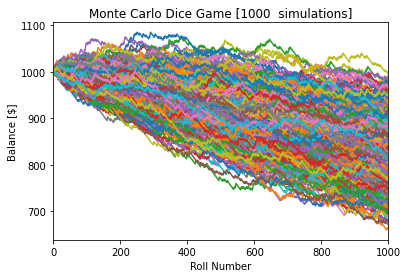

Average win probability after 1000 runs: 0.16630000000000028
Average ending balance after 1000 runs: $831.5


In [ ]:
fig = plt.figure()
plt.title("Monte Carlo Dice Game [" + str(num_simulations) + "  simulations]")
plt.xlabel("Roll Number")
plt.ylabel("Balance [$]")
plt.xlim([0, max_num_rolls])

for i in range(num_simulations):
    balance = [1000]
    num_rolls = [0]
    num_wins = 0
    # Выполняется до тех пор пока игрок не выкинет 1000 раз
    while num_rolls[-1] < max_num_rolls:
        same = roll_dice()
        # Результат если кости одинаковые
        if same:
            balance.append(balance[-1] + 4 * bet)
            num_wins += 1
        # Результат если кости разные
        else:
            balance.append(balance[-1] - bet)

        num_rolls.append(num_rolls[-1] + 1)
    # Сохраняем отслеживаемую переменную и добавляем строку к рисунку
    win_probability.append(num_wins/num_rolls[-1])
    end_balance.append(balance[-1])
    plt.plot(num_rolls, balance)

# Выведем график после завершения моделирования
plt.show()

# Усредненная вероятность выигрыша и конечного баланса
overall_win_probability = sum(win_probability)/len(win_probability)
overall_end_balance = sum(end_balance)/len(end_balance)
# Вывод средних значений
print("Average win probability after " + str(num_simulations) + " runs: " + str(overall_win_probability))
print("Average ending balance after " + str(num_simulations) + " runs: $" + str(overall_end_balance))